In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from PIL import Image


In [28]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [29]:
torch.manual_seed(42)
np.random.seed(42)

In [30]:
models = {
    'Shallow MLP': nn.Sequential(
        nn.Linear(128*128, 32),
        nn.ReLU(),
        nn.Linear(32, 3)
    ),
    'Deep MLP': nn.Sequential(
        nn.Linear(128*128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    ),
    'Shallow CNN': nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*64*64, 3) 
    ),
    'Deep CNN': nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64*32*32, 128),  
        nn.ReLU(),
        nn.Linear(128, 3)
    )

}

In [31]:
class AIdetec_CNN(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [32]:
class AIdetec_MLP(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Grayscale(),
            transforms.Lambda(lambda x: x.view(-1))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [33]:
dataset_CNN = AIdetec_CNN('../data', 128)

train_size_CNN = 800    
val_size_CNN = 200

train_CNN, val_CNN = random_split(dataset_CNN, [train_size_CNN, val_size_CNN])




dataset_MLP = AIdetec_MLP('../data', 128)

train_size_MLP = 800    
val_size_MLP = 200

train_MLP, val_MLP = random_split(dataset_MLP, [train_size_MLP, val_size_MLP])

In [34]:
dl_train_CNN = DataLoader(train_CNN, batch_size=32, shuffle=True)
dl_val_CNN = DataLoader(val_CNN, batch_size=32, shuffle=True)

dl_train_MLP = DataLoader(train_MLP, batch_size=32, shuffle=True)
dl_val_MLP = DataLoader(val_MLP, batch_size=32, shuffle=True)

In [35]:
size = 0
for batch_x, batch_y in dl_train_MLP:
  size += batch_x.shape[0]
  print(batch_x.shape), print(batch_y.shape)
print("Total size: ", size)

torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 

In [36]:
def train_model(model, train_dl, val_dl, epochs=1000, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for batch_x, batch_y in train_dl:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == batch_y).sum().item()

        train_loss_history.append(train_loss / len(train_dl))
        train_acc_history.append(train_correct / len(train_dl.dataset))

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for batch_x, batch_y in val_dl:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_correct += (predicted == batch_y).sum().item()

        val_loss_history.append(val_loss / len(val_dl))
        val_acc_history.append(val_correct / len(val_dl.dataset))

        print(f"Epoch {epoch}, Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]:.4f}, Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]:.4f}")



    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [37]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Shallow MLP'], dl_train_MLP, dl_val_MLP, epochs=10, lr=0.0001)

Epoch 0, Train Loss: 0.7704, Train Acc: 0.5000, Val Loss: 0.7440, Val Acc: 0.4700
Epoch 1, Train Loss: 0.7459, Train Acc: 0.5062, Val Loss: 0.7269, Val Acc: 0.5250
Epoch 2, Train Loss: 0.6951, Train Acc: 0.5463, Val Loss: 0.6935, Val Acc: 0.5650
Epoch 3, Train Loss: 0.7057, Train Acc: 0.5200, Val Loss: 0.6952, Val Acc: 0.5550
Epoch 4, Train Loss: 0.6826, Train Acc: 0.5500, Val Loss: 0.7102, Val Acc: 0.5450
Epoch 5, Train Loss: 0.6827, Train Acc: 0.5450, Val Loss: 0.7318, Val Acc: 0.4700
Epoch 6, Train Loss: 0.7048, Train Acc: 0.5075, Val Loss: 0.7162, Val Acc: 0.4750
Epoch 7, Train Loss: 0.6562, Train Acc: 0.6125, Val Loss: 0.7056, Val Acc: 0.5650
Epoch 8, Train Loss: 0.6559, Train Acc: 0.6012, Val Loss: 0.7037, Val Acc: 0.4650
Epoch 9, Train Loss: 0.6652, Train Acc: 0.5650, Val Loss: 0.7072, Val Acc: 0.4700


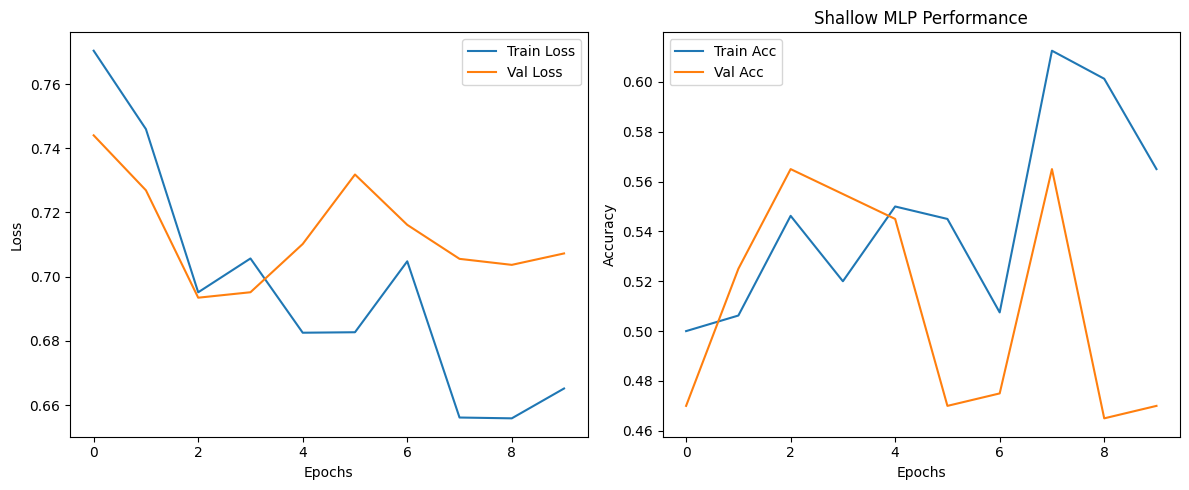

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [39]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Deep MLP'], dl_train_MLP, dl_val_MLP, epochs=10, lr=0.0001)

Epoch 0, Train Loss: 0.8045, Train Acc: 0.5138, Val Loss: 0.7051, Val Acc: 0.5300
Epoch 1, Train Loss: 0.7012, Train Acc: 0.5150, Val Loss: 0.7191, Val Acc: 0.4700
Epoch 2, Train Loss: 0.6940, Train Acc: 0.5487, Val Loss: 0.7071, Val Acc: 0.4750
Epoch 3, Train Loss: 0.6946, Train Acc: 0.5613, Val Loss: 0.6955, Val Acc: 0.5250
Epoch 4, Train Loss: 0.7046, Train Acc: 0.4900, Val Loss: 0.7097, Val Acc: 0.4850
Epoch 5, Train Loss: 0.6896, Train Acc: 0.5387, Val Loss: 0.6874, Val Acc: 0.5450
Epoch 6, Train Loss: 0.6833, Train Acc: 0.5537, Val Loss: 0.6904, Val Acc: 0.5550
Epoch 7, Train Loss: 0.6976, Train Acc: 0.5363, Val Loss: 0.6966, Val Acc: 0.5550
Epoch 8, Train Loss: 0.6796, Train Acc: 0.5900, Val Loss: 0.6929, Val Acc: 0.5400
Epoch 9, Train Loss: 0.6807, Train Acc: 0.5725, Val Loss: 0.6964, Val Acc: 0.5300


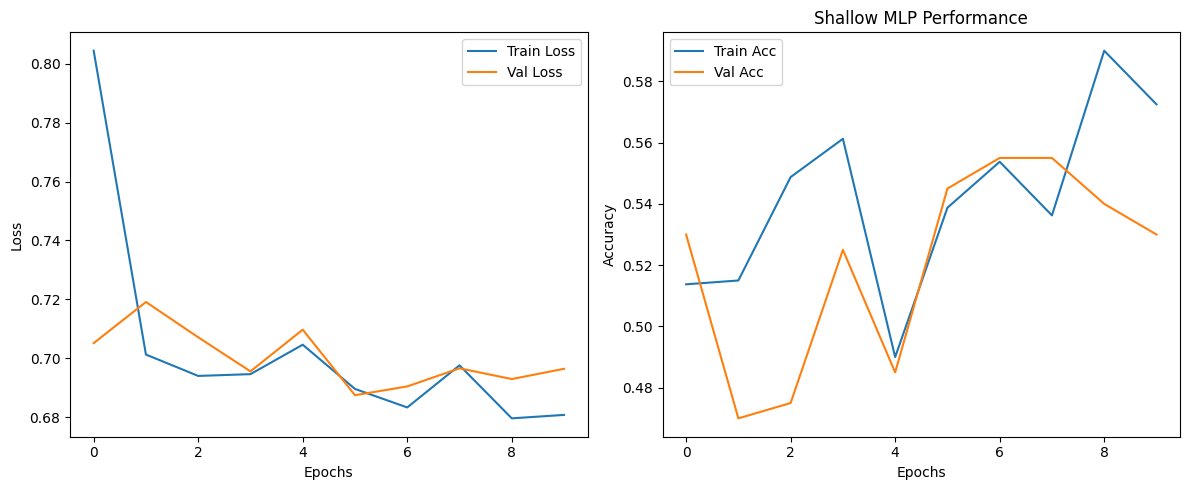

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [41]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Shallow CNN'], dl_train_CNN, dl_val_CNN, epochs=10, lr=0.0001)

Epoch 0, Train Loss: 0.6795, Train Acc: 0.6225, Val Loss: 0.6182, Val Acc: 0.6000
Epoch 1, Train Loss: 0.5274, Train Acc: 0.7725, Val Loss: 0.5078, Val Acc: 0.8250
Epoch 2, Train Loss: 0.4518, Train Acc: 0.8213, Val Loss: 0.4418, Val Acc: 0.8450
Epoch 3, Train Loss: 0.4049, Train Acc: 0.8475, Val Loss: 0.4310, Val Acc: 0.7900
Epoch 4, Train Loss: 0.3611, Train Acc: 0.8875, Val Loss: 0.3866, Val Acc: 0.8550
Epoch 5, Train Loss: 0.3381, Train Acc: 0.8900, Val Loss: 0.3984, Val Acc: 0.8500
Epoch 6, Train Loss: 0.3009, Train Acc: 0.8975, Val Loss: 0.3710, Val Acc: 0.8650
Epoch 7, Train Loss: 0.2819, Train Acc: 0.9213, Val Loss: 0.3511, Val Acc: 0.8600
Epoch 8, Train Loss: 0.2721, Train Acc: 0.9113, Val Loss: 0.4024, Val Acc: 0.8700
Epoch 9, Train Loss: 0.2543, Train Acc: 0.9250, Val Loss: 0.3333, Val Acc: 0.8850


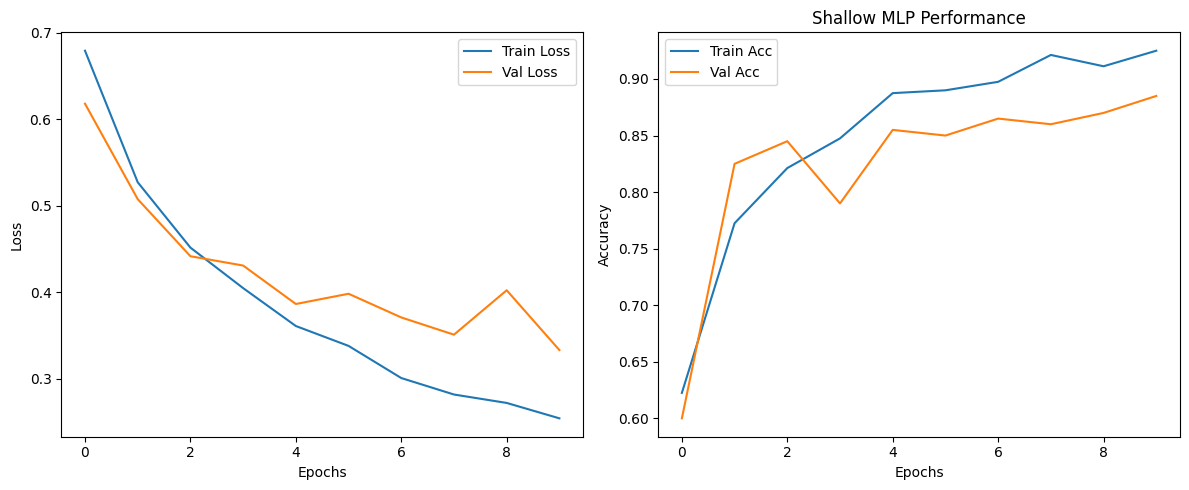

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [43]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Deep CNN'], dl_train_CNN, dl_val_CNN, epochs=10, lr=0.0001)

Epoch 0, Train Loss: 0.6890, Train Acc: 0.5787, Val Loss: 0.5838, Val Acc: 0.7450
Epoch 1, Train Loss: 0.4980, Train Acc: 0.8050, Val Loss: 0.4404, Val Acc: 0.8600
Epoch 2, Train Loss: 0.4255, Train Acc: 0.8237, Val Loss: 0.4185, Val Acc: 0.8250
Epoch 3, Train Loss: 0.3518, Train Acc: 0.8788, Val Loss: 0.3375, Val Acc: 0.8750
Epoch 4, Train Loss: 0.3087, Train Acc: 0.8875, Val Loss: 0.4449, Val Acc: 0.7950
Epoch 5, Train Loss: 0.2983, Train Acc: 0.8862, Val Loss: 0.3293, Val Acc: 0.8800
Epoch 6, Train Loss: 0.2556, Train Acc: 0.9075, Val Loss: 0.2909, Val Acc: 0.8800
Epoch 7, Train Loss: 0.2448, Train Acc: 0.9062, Val Loss: 0.3195, Val Acc: 0.8650
Epoch 8, Train Loss: 0.2294, Train Acc: 0.9050, Val Loss: 0.3134, Val Acc: 0.8800
Epoch 9, Train Loss: 0.2064, Train Acc: 0.9213, Val Loss: 0.2782, Val Acc: 0.8700


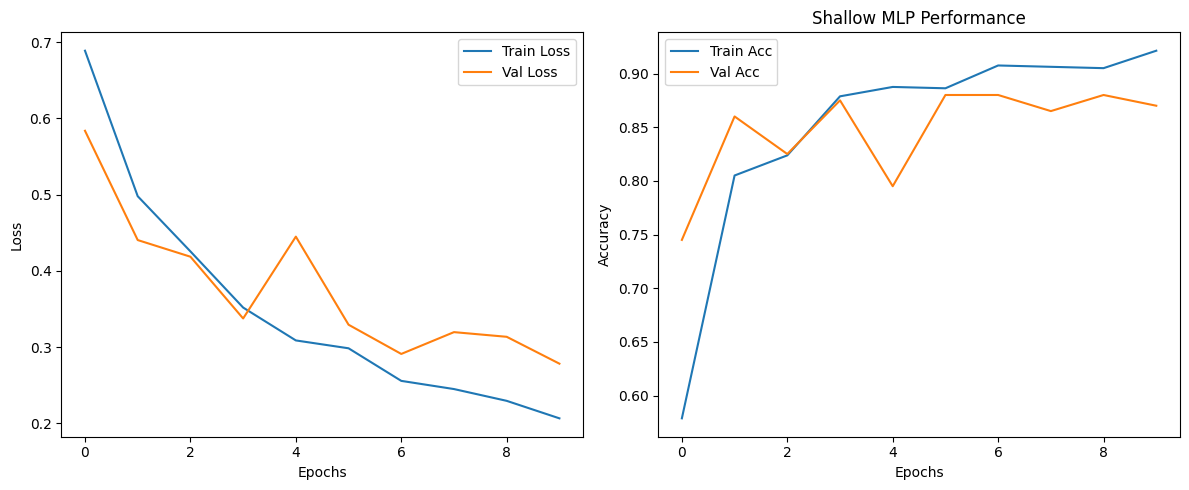

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [45]:
models['Deep CNN Reg'] = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64*32*32, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 3)
)

In [46]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Deep CNN Reg'], dl_train_CNN, dl_val_CNN, epochs=10, lr=0.0001)

Epoch 0, Train Loss: 0.8649, Train Acc: 0.6825, Val Loss: 1.3174, Val Acc: 0.5300
Epoch 1, Train Loss: 0.3521, Train Acc: 0.8488, Val Loss: 0.3700, Val Acc: 0.8300
Epoch 2, Train Loss: 0.2873, Train Acc: 0.8825, Val Loss: 0.3075, Val Acc: 0.8450
Epoch 3, Train Loss: 0.2598, Train Acc: 0.8950, Val Loss: 0.3511, Val Acc: 0.8550
Epoch 4, Train Loss: 0.2355, Train Acc: 0.9075, Val Loss: 0.2973, Val Acc: 0.8800
Epoch 5, Train Loss: 0.1983, Train Acc: 0.9275, Val Loss: 0.2618, Val Acc: 0.8950
Epoch 6, Train Loss: 0.2004, Train Acc: 0.9125, Val Loss: 0.3555, Val Acc: 0.8550
Epoch 7, Train Loss: 0.1642, Train Acc: 0.9375, Val Loss: 0.2837, Val Acc: 0.8750
Epoch 8, Train Loss: 0.1409, Train Acc: 0.9513, Val Loss: 0.3263, Val Acc: 0.8500
Epoch 9, Train Loss: 0.1644, Train Acc: 0.9300, Val Loss: 0.3884, Val Acc: 0.8400


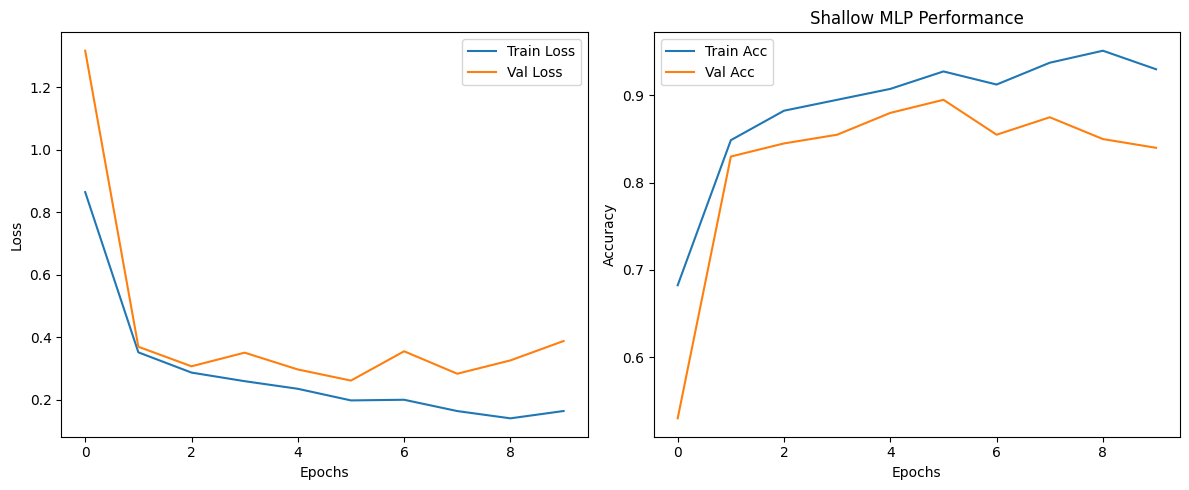

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()